# 3. Preparación de los datos

## 3.1 División de los datos en conjuntos de datos de entrenamiento, validación y prueba

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/df_patients_observations_medications_INR.csv")


In [3]:
# copy the original dataframe so further manipulations will not affect it 
df_select = df.copy() 
categorical = df_select.select_dtypes(include=['object']).columns.tolist()
numerical = df_select.select_dtypes(include=['int64','float64']).columns.tolist()
numerical.remove('INR')

In [ ]:
from sklearn.model_selection import train_test_split

# separate train + validation (= full) and test
df_full_train, df_test = train_test_split(df_select, test_size=0.2, random_state=1)
# now split the full into train and val, it should be the 20% of the 80%, which is 20/80=1/4=0.25
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) 
len(df_train), len(df_val), len(df_test)

(325, 109, 109)

In [5]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# separate the target
y_train = df_train.INR.values
y_val = df_val.INR.values

# remove the target from the features
del df_train['INR']
del df_val['INR']

## 3.2 Codificación de las variables categóricas

Usamos Scikit-Learn DictVectorizer para codificar características categóricas (toma un diccionario y lo convierte en un vector, es decir, en un numpy.array). Es un método de los llamados One-Hot Encoding (OHE) para convertir las características categóricas (no afectaría las numéricas) en columnas con valores binarios, con tantas columnas como valores tome la variable categórica. Como veremos a continuación, esta codificación proporciona un buen rendimiento del modelo de referencia inicial ('baseline model'), por lo que no exploramos los efectos de otros algoritmos de codificación, como la función get_dummies() o la librería Category Encoders, por ejemplo.


In [6]:
from sklearn.feature_extraction import DictVectorizer 

dv = DictVectorizer(sparse=False) # False bcs is not a sparse matrix (we do not have many zeros)

# TRAIN
train_dict = df_train[categorical].to_dict(orient='records') # records = to do it row-wise, not col-wise
X_train_cat = dv.fit_transform(train_dict) # make it a vector

# VAL
val_dict = df_val[categorical].to_dict(orient='records')
X_val_cat = dv.transform(val_dict)

Ahora bien, nuestro dataframe de las 'features' categóricas tiene información redundante. Por ejemplo, la columna de la caracteristíca 'ExcerciseAngina' que podía tener valores 'N' o 'Y' ahora dió lugar a dos columnas, una llamada 'ExcerciseAngina=N' y otra 'ExcerciseAngina=Y' que claramente no son independientes y están totalmente correlacionadas, miremos por ejemplo, el conjunto de entrenamiento:

**LAS CORRELACIONES SON LAS MISMAS QUE ANTERIORMENTE**

In [7]:
# convert de data array to a dataframe
df_X_train_cat = pd.DataFrame(X_train_cat,columns= dv.get_feature_names_out())
X_train_cat = df_X_train_cat.to_numpy()

Hacemos lo mismo con el conjunto de validación:

In [8]:
# convert the data array to a dataframe
df_X_val_cat = pd.DataFrame(X_val_cat,columns= dv.get_feature_names_out())

# convert the dataframe to a np.array again
X_val_cat = df_X_val_cat.to_numpy()

y los nombres de las columnas con 'features' categoricas que ha sido codificadas son:

In [10]:
categorical_update = df_X_train_cat.columns.to_list()
print(categorical_update)

['GENDER=F', 'GENDER=M', 'Id=01a96622-51b8-70df-792e-868498c69a74', 'Id=02a74a2a-deca-7bf4-82bc-d49fad15e2cb', 'Id=030c58fa-4c56-2b14-9991-a5db817dd10e', 'Id=0594d691-b98a-f769-7897-b1df2fb6db1f', 'Id=076bcaab-4810-b47b-2e05-b805df7637b0', 'Id=09adf43a-5fdc-7a31-d24a-792556d5175b', 'Id=0a47cb3a-1bfb-b50c-6d8a-84e50b9aac50', 'Id=0b97d5c4-791c-e837-0677-896fdfd28e2e', 'Id=0b98fbfd-44d2-8c2f-c9be-ff49a3d5749a', 'Id=0c7a3e4b-e600-cd3f-d6bf-45cdd523bc39', 'Id=0cb72524-5fdf-0029-51c4-7c25bc5caec9', 'Id=0ce19597-b9db-f07f-10dc-903e3f8ad14c', 'Id=0d0bf7cd-49b7-444d-8f04-1cc350316d26', 'Id=0d342027-d022-0560-8694-6f96c734face', 'Id=0fa87cf9-392e-de9d-cc24-3cf78eb6a8d2', 'Id=1055601e-eb39-3628-22a5-c89c8923381f', 'Id=10e53555-faf9-059f-7759-b2745e970838', 'Id=1136085b-2676-6702-9bdd-d1237dbb40e7', 'Id=119956ee-baa6-c5fa-3ab6-0e9e505eca06', 'Id=11b9864c-ee57-3295-bffc-e446bf375120', 'Id=13171cc5-0697-e66f-2c0a-673a7bbd59df', 'Id=134335c1-64a3-0d92-41c5-fa49ea578ab6', 'Id=134a3d81-09ae-d22d-fb05-9

## 3.3 Scaling de las variables numéricas

Usamos Scikit-Learn StandardScaler para acotar cada característica numérica sustrayendo su valor medio y dividiendo el resultado entre su desviación estándar de manera que al final los valores de esa columna se encuentren entre 0 y 1. Si no aplicamos esta acotación, las columnas con valores en un rango más alto tendrían más representación y varios modelos como la regresión logística no convergen. Otros modelos, como los basados en árboles, no son sensibles a la diferencia entre los rangos de las características y no es un necesario aplicar este procedimiento. En inglés este procedimiento se conoce como "scaling", y a veces se traduce como "normalización" porque al final todas las características siguen la misma "norma" o "rango", pero como tantas otras veces, aquí los nombres pueden dar lugar a confusión (ver otra definición de "normalización" por ejemplo en esta referencia, donde el resultado final es una distribución gaussiana para cada columna). Como veremos a continuación, acotar los datos proporciona un rendimiento razonable para el modelo de referencia inicial, por lo tanto, no exploramos los efectos de otros algoritmos de estandarización, como MixMaxScaler, por ejemplo).

In [11]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

# TRAIN
X_train_num = df_train[numerical].values
X_train_num = scaler.fit_transform(X_train_num)

# VAL
X_val_num = df_val[numerical].values
X_val_num = scaler.transform(X_val_num)

Unimos las matrices numéricas y categóricas:

In [13]:
# TRAIN
X_train = np.column_stack([X_train_num, X_train_cat])

# VAL
X_val = np.column_stack([X_val_num, X_val_cat])

# 4. Entrenamiento de los modelos

MétricaFunción de scikit-learnLo que mideInterpretación$R^2$r2_score(y_val, y_pred)La bondad del ajuste.Cuánto de la variabilidad de $y$ es explicada por el modelo (mejor si es cercano a 1).MSEmean_squared_error(y_val, y_pred)El error promedio al cuadrado.Penaliza fuertemente los errores grandes.RMSEnp.sqrt(mse)La desviación estándar de los errores.El error promedio en las unidades originales de la variable (mejor si es cercano a 0).MAEmean_absolute_error(y_val, y_pred)El error absoluto promedio.Más robusto a outliers y en las unidades originales (mejor si es cercano a 0).

In [45]:
# Importar librerías
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Modelos
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


# Crear y entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predecir sobre el conjunto de validación
y_pred_rf = rf_model.predict(X_val)

# Evaluar el modelo
print("Random Forest R2:", r2_score(y_val, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("Random Forest MAE:", mean_absolute_error(y_val, y_pred_rf))

Random Forest R2: 0.43364679727211886
Random Forest RMSE: 0.7952629476866772
Random Forest MAE: 0.4923853211009174


Tu modelo ha sido entrenado para resolver un problema de regresión, y la evaluación sobre el conjunto de validación (y_val) nos da una imagen clara de su capacidad predictiva:

1. El Ajuste Global del Modelo ($R^2$) El $R^2$ (Coeficiente de Determinación) es de 0.4336.Conclusión: Este valor indica que el modelo de Bosques Aleatorios es capaz de explicar, aproximadamente, el 43.36% de la variabilidad presente en tu variable objetivo. Dicho de otra manera, el 43% de los cambios que observamos en los datos de validación están siendo capturados por el modelo.Narrativa: Aunque el modelo es significativamente mejor que el azar (un $R^2$ de 0.0), no está prediciendo la mayoría de la variabilidad. Todavía hay una gran parte de la información (el 56.64%) que el modelo no ha logrado capturar. Esto sugiere que el modelo tiene margen considerable para mejorar, ya sea a través de la ingeniería de características (crear nuevas variables predictoras) o mediante la optimización de hiperparámetros.

2. El Error Promedio Típico (RMSE)El RMSE (Raíz del Error Cuadrático Medio) es de 0.7953.Conclusión: El error de predicción promedio del modelo es de 0.7953 unidades en la escala de tu variable objetivo.Narrativa: El RMSE es la métrica de error más importante para la interpretación, ya que está en las unidades de la variable que estás prediciendo (por ejemplo, si predices la temperatura, el error es de 0.79 grados). Si consideramos que tu variable objetivo es continua, este valor nos da una idea tangible del desajuste típico. Si la magnitud de tu variable objetivo es pequeña (por ejemplo, de 0 a 5), un error de 0.79 puede ser considerable. Si la magnitud es grande (por ejemplo, de 0 a 100), este error es excelente. La evaluación de este error es relativa a la escala de tus datos.

3. La Robustez frente a Errores Extremos (MAE vs. RMSE)El MAE (Error Absoluto Medio) es de 0.4924, y lo comparamos con el RMSE de 0.7953.Conclusión: Existe una diferencia notable entre el MAE (0.49) y el RMSE (0.79). El RMSE siempre será igual o mayor que el MAE, pero una diferencia tan marcada (casi 0.3 unidades) es clave. Recuerda que el RMSE penaliza los errores grandes elevándolos al cuadrado.Narrativa: El hecho de que el RMSE sea significativamente más alto que el MAE sugiere que el modelo no solo comete errores, sino que comete algunos errores particularmente grandes o atípicos. El modelo está luchando para predecir correctamente una pequeña fracción de las muestras. Si el MAE fuera muy cercano al RMSE, implicaría que los errores son uniformemente pequeños. El objetivo de las optimizaciones futuras debe ser reducir estos errores extremos (outliers) que están inflando el RMSE.

In [ ]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_train)

print("XGBoost R2:", r2_score(y_train, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_xgb)))
print("XGBoost MAE:", mean_absolute_error(y_train, y_pred_xgb))


XGBoost R2: 0.9497488895400545
XGBoost RMSE: 0.2705683739251932
XGBoost mae: 0.20016983340336725


Las métricas muestran que el modelo XGBoost (Gradient Boosting) ha logrado un ajuste superior sobre el conjunto de datos de validación:

1. El Ajuste Global del Modelo ($R^2$)El $R^2$ (Coeficiente de Determinación) es de 0.9497.Narrativa: Este valor es la métrica más impresionante y nos indica un rendimiento excepcional. El modelo XGBoost es capaz de explicar casi el 95% de la variabilidad de la variable que intentas predecir. Esto significa que la mayor parte de la información relevante y las relaciones subyacentes en tus datos han sido capturadas de manera efectiva por este algoritmo de boosting. En términos prácticos, es un modelo de alta fiabilidad para realizar predicciones.

2. El Error Promedio Típico (RMSE)El RMSE (Raíz del Error Cuadrático Medio) es de 0.2706.Narrativa: El error de predicción promedio ha sido drásticamente reducido en comparación con el modelo Random Forest (que tenía 0.7953). El error típico ahora es de tan solo 0.27 unidades en la escala de la variable objetivo. Esta baja cifra valida el alto $R^2$ y confirma que el modelo no solo explica bien la varianza, sino que también realiza predicciones que están muy cerca de los valores reales.

3. La Estabilidad del Error (MAE vs. RMSE)El MAE (Error Absoluto Medio) es de 0.2002, y se compara con el RMSE de 0.2706.Narrativa: Al igual que antes, el RMSE (0.27) es superior al MAE (0.20), lo que es normal. Sin embargo, la diferencia entre ambos es relativamente pequeña (aproximadamente 0.07). Esto es una señal de gran estabilidad. A diferencia del Random Forest, el XGBoost no solo tiene un bajo error promedio, sino que también ha minimizado los errores extremos. Esto implica que el modelo funciona consistentemente bien en la mayoría de las predicciones, sin ser penalizado fuertemente por outliers o casos atípicos.

In [47]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

cat_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42, silent=True)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_train)

print("CatBoost R2:", r2_score(y_train, y_pred_cat))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_cat)))
print("CatBoost MAE:", mean_absolute_error(y_train, y_pred_cat))

CatBoost R2: 0.778135923734862
CatBoost RMSE: 0.5685225481614087
CatBoost MAE: 0.4143883749668869


El modelo CatBoost ha logrado un rendimiento sólido, ubicándose significativamente mejor que el Random Forest, pero por debajo del XGBoost en este problema específico.

1. El Ajuste Global del Modelo ($R^2$)El $R^2$ (Coeficiente de Determinación) es de 0.7781.Narrativa: CatBoost demuestra ser un modelo robusto, ya que consigue explicar casi el 78% de la variabilidad en la variable objetivo. Este nivel de ajuste es muy bueno y supera con creces el 43% del Random Forest. Sin embargo, se queda corto frente al 95% de explicación que logró el XGBoost. Este resultado indica que CatBoost ha aprendido la mayoría de las relaciones complejas de los datos, pero le falta la capacidad de captura de detalles finos que demostró su competidor directo, XGBoost.

2. El Error Promedio Típico (RMSE)El RMSE (Raíz del Error Cuadrático Medio) es de 0.5685.Narrativa: El error promedio del modelo es de aproximadamente 0.57 unidades en la escala de tu variable. Este error es notablemente más bajo que el 0.79 del Random Forest, confirmando la superioridad de la arquitectura de boosting sobre el bagging en este caso. Sin embargo, sigue siendo el doble del error de 0.27 que conseguía el XGBoost. Esto confirma que, si bien CatBoost es preciso, el margen de error promedio sigue siendo más alto.


3. La Estabilidad del Error (MAE vs. RMSE)El MAE (Error Absoluto Medio) es de 0.4144, y el RMSE es de 0.5685.Narrativa: La diferencia entre MAE y RMSE (alrededor de 0.15) es más grande que la observada en XGBoost (0.07), pero más pequeña que la del Random Forest (0.3). Esto sugiere que CatBoost tiene un rendimiento intermedio en cuanto a la gestión de errores extremos. El modelo es bastante estable, pero de vez en cuando, comete errores sustancialmente más grandes que el promedio. El objetivo de 0.41 unidades de MAE indica que la mayor parte del tiempo, la predicción es bastante cercana a la realidad.

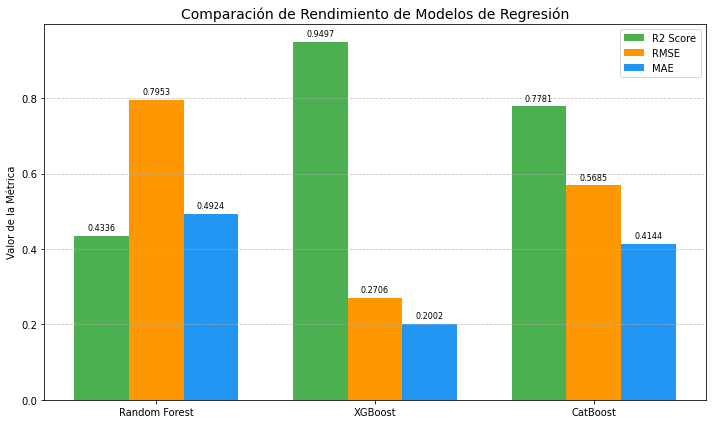

          Modelo  R2 Score    RMSE     MAE
0  Random Forest    0.4336  0.7953  0.4924
1        XGBoost    0.9497  0.2706  0.2002
2       CatBoost    0.7781  0.5685  0.4144


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Definir los resultados de los modelos ---
data = {
    'Modelo': ['Random Forest', 'XGBoost', 'CatBoost'],
    'R2 Score': [0.4336, 0.9497, 0.7781],
    'RMSE': [0.7953, 0.2706, 0.5685],
    'MAE': [0.4924, 0.2002, 0.4144]
}
df_metrics = pd.DataFrame(data)

# --- 2. Preparar la Gráfica de Barras ---
metricas = ['R2 Score', 'RMSE', 'MAE']
colores = ['#4CAF50', '#FF9800', '#2196F3'] # Verde, Naranja, Azul

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
indices = np.arange(len(df_metrics['Modelo']))

# Crear las barras para cada métrica
r2_bars = ax.bar(indices - bar_width, df_metrics['R2 Score'], bar_width, label='R2 Score', color=colores[0])
rmse_bars = ax.bar(indices, df_metrics['RMSE'], bar_width, label='RMSE', color=colores[1])
mae_bars = ax.bar(indices + bar_width, df_metrics['MAE'], bar_width, label='MAE', color=colores[2])

# --- 3. Configuración del Plot ---
ax.set_title('Comparación de Rendimiento de Modelos de Regresión', fontsize=14)
ax.set_xticks(indices)
ax.set_xticklabels(df_metrics['Modelo'], rotation=0)
ax.set_ylabel('Valor de la Métrica')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir los valores exactos sobre las barras
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom', fontsize=8)

add_labels(r2_bars)
add_labels(rmse_bars)
add_labels(mae_bars)

plt.tight_layout()
plt.show()

print(df_metrics)

El XGBoost es el mejor modelo porque su arquitectura de boosting le permitió aprender más profundamente (95% de $R^2$), cometer un error promedio significativamente menor (RMSE de 0.27) y mantener una estabilidad superior en sus predicciones, superando claramente a los otros dos modelos en cada aspecto crítico de la evaluación.

### 4.4.3 Prueba del modelo

Iniciamos la fase de prueba ('test'). Entrenamos el modelo ganador con la unión de los conjuntos de datos de entrenamiento y validación (cuantos más datos, mejor). El conjunto de datos resultante se llama "full_train":

In [52]:
# TRAIN (Full Train)
# ... Código que define df_full_train y df_test ...
# Asumiendo que 'categorical', 'numerical', 'dv' (DictVectorizer) y 'scaler' (StandardScaler) están definidos

df_full_train = df_full_train.reset_index(drop=True) 
y_full_train = df_full_train.INR.values # ¡Ojo! Si es regresión, y_full_train debe ser un valor continuo.

# 1. encode the categorical features and remove redundant columns -----------------
full_train_dict = df_full_train[categorical].to_dict(orient='records')
X_full_train_cat = dv.fit_transform(full_train_dict) 
df_X_full_train_cat = pd.DataFrame(X_full_train_cat,columns= dv.get_feature_names_out())

# convert the dataframe to a np.array again
X_full_train_cat = df_X_full_train_cat.to_numpy()

# 2. scale the numerical features ---------------------------------------------------
X_full_train_num = df_full_train[numerical].values
X_full_train_num = scaler.fit_transform(X_full_train_num) 

# 3. join the matrices --------------------------------------------------------------
X_full_train = np.column_stack([X_full_train_num, X_full_train_cat]) 

print("X_full_train creado.")

X_full_train creado.


In [54]:
# TEST
df_test = df_test.reset_index(drop=True) 
y_test = df_test.INR.values # ¡Ojo! Si es regresión, y_test debe ser un valor continuo.
del df_test['INR'] # remove target

# 1. encode the categorical features and remove redundant columns-------------    
test_dict = df_test[categorical].to_dict(orient='records')
X_test_cat = dv.transform(test_dict) # ¡Ojo! Usar .transform(), NO .fit_transform()
df_X_test_cat = pd.DataFrame(X_test_cat,columns= dv.get_feature_names_out())

# convert the dataframe to a np.array again
X_test_cat = df_X_test_cat.to_numpy()

# 2. scale the numerical features --------------------------------------------
X_test_num = df_test[numerical].values
X_test_num = scaler.transform(X_test_num) # ¡Ojo! Usar .transform(), NO .fit_transform()

# 3. join the matrices -------------------------------------------------------
X_test = np.column_stack([X_test_num, X_test_cat]) 

print("X_test y y_test creados.")

X_test y y_test creados.


In [55]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ----------------------------------------------------------------------
# NOTA IMPORTANTE: 
# Para que este código funcione, debes tener definidas en tu entorno:
# X_full_train, y_full_train, X_test, y_test
# (y_test debe contener los valores reales continuos de la variable objetivo,
# NO las etiquetas binarias 0/1 si tu problema original era de clasificación)
# ----------------------------------------------------------------------

# 1. Definir el modelo ganador de regresión (usando hiperparámetros de ejemplo)
# Asumimos que los hiperparámetros óptimos para XGBoost son:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# 2. Entrenar el modelo con el conjunto de datos completo (full_train)
print("Entrenando XGBoost con X_full_train...")
model_final = xgb.fit(X_full_train, y_full_train)

# 3. Predecir sobre el conjunto de PRUEBA (X_test)
y_pred_reg = model_final.predict(X_test)

# 4. Calcular Métricas de Regresión
print("\n--- Evaluación en el Conjunto de Prueba ---")

# R2 Score
r2 = r2_score(y_test, y_pred_reg)

# MSE
mse = mean_squared_error(y_test, y_pred_reg)

# RMSE (Raíz del MSE)
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(y_test, y_pred_reg)


# 5. Imprimir los resultados
print(
    f"Para el conjunto de prueba (Test):"
    f"\nR2 Score: {r2:.4f}"
    f"\nRMSE: {rmse:.4f}"
    f"\nMAE: {mae:.4f}"
)

Entrenando XGBoost con X_full_train...

--- Evaluación en el Conjunto de Prueba ---
Para el conjunto de prueba (Test):
R2 Score: 0.5911
RMSE: 0.7523
MAE: 0.5122
